This is the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# we are working with PBMCs so lets store some marker genes
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

marker_genes_dict = {
    'CD14 Mono': ['CD14', 'LYZ'],
    'CD16 Mono': ['FCGR3A', 'MS4A7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'NK': ['GNLY', 'NKG7'],
    'B Cell': ['MS4A1', 'CD79A'],
    'CD4 T': ['IL7R'],
    'CD4 T Naive': ['CCR7'],
    'CD4 T Memory': ['S100A4'],
    'CD8 T': ['CD8A'],
    'Megakaryocytes': ['PPBP']
}

genes_annot_dict = {
    'CD14': ['CD14 (CD14 Mono)'],
    'LYZ': ['LYZ (CD14 Mono)'],
    'FCGR3A': ['FCGR3A (CD16 Mono)'],
    'MS4A7': ['MS4A7 (CD16 Mono)'],
    'FCER1A': ['FCER1A (Dendritic)'],
    'CST3': ['CST3 (Dendritic)'],
    'GNLY': ['GNLY (NK)'],
    'NKG7': ['NKG7 (NK)'],
    'MS4A1': ['MS4A1 (B cell)'],
    'CD79A': ['CD79A (B cell)'],
    'IL7R': ['IL7R (CD4T)'],
    'CCR7': ['CCR7 (Naive CD4T)'],
    'S100A4': ['S100A4 (Memory CD4T)'],
    'CD8A': ['CD8A (CD8 T)'],
    'PPBP': ['PPBP (Megak)']
}



scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [2]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/pbmc3k/hg19/"

results_file = f"{data_path}/pbmc3k.h5ad"

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/beevol-home-davidson-checkouts-sc_bulk_ood-evaluation_experiments-pbmc3k-..-..-data-single_cell_data-pbmc3k-hg19-matrix.h5ad


In [3]:
# make cell type specific marker annotation


# Initialize empty column in cell metadata
adata.var['gene_annot'] = adata.var_names

# Generate new assignments
for i in genes_annot_dict.keys():
    ind = np.where(pd.Series(adata.var_names).isin([i]))[0]
    adata.var['gene_annot'].iloc[ind] = genes_annot_dict[i]
adata.var['gene_annot'].iloc[ind]

PPBP    PPBP (Megak)
Name: gene_annot, dtype: object

## Preprocessing

In [4]:
# lets see whats in adata
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids', 'gene_annot'

normalizing counts per cell
    finished (0:00:00)


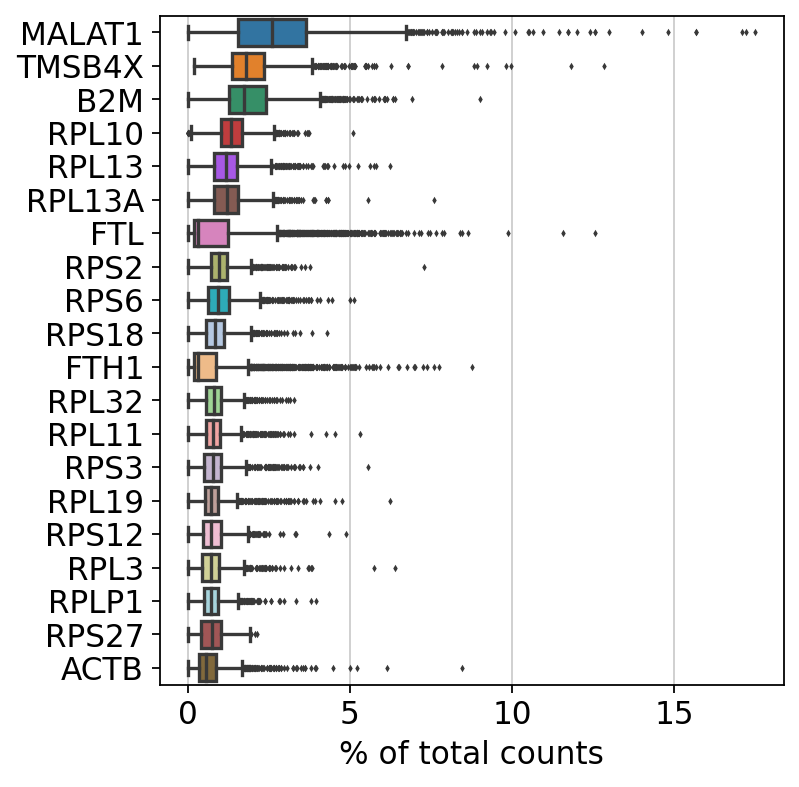

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [6]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


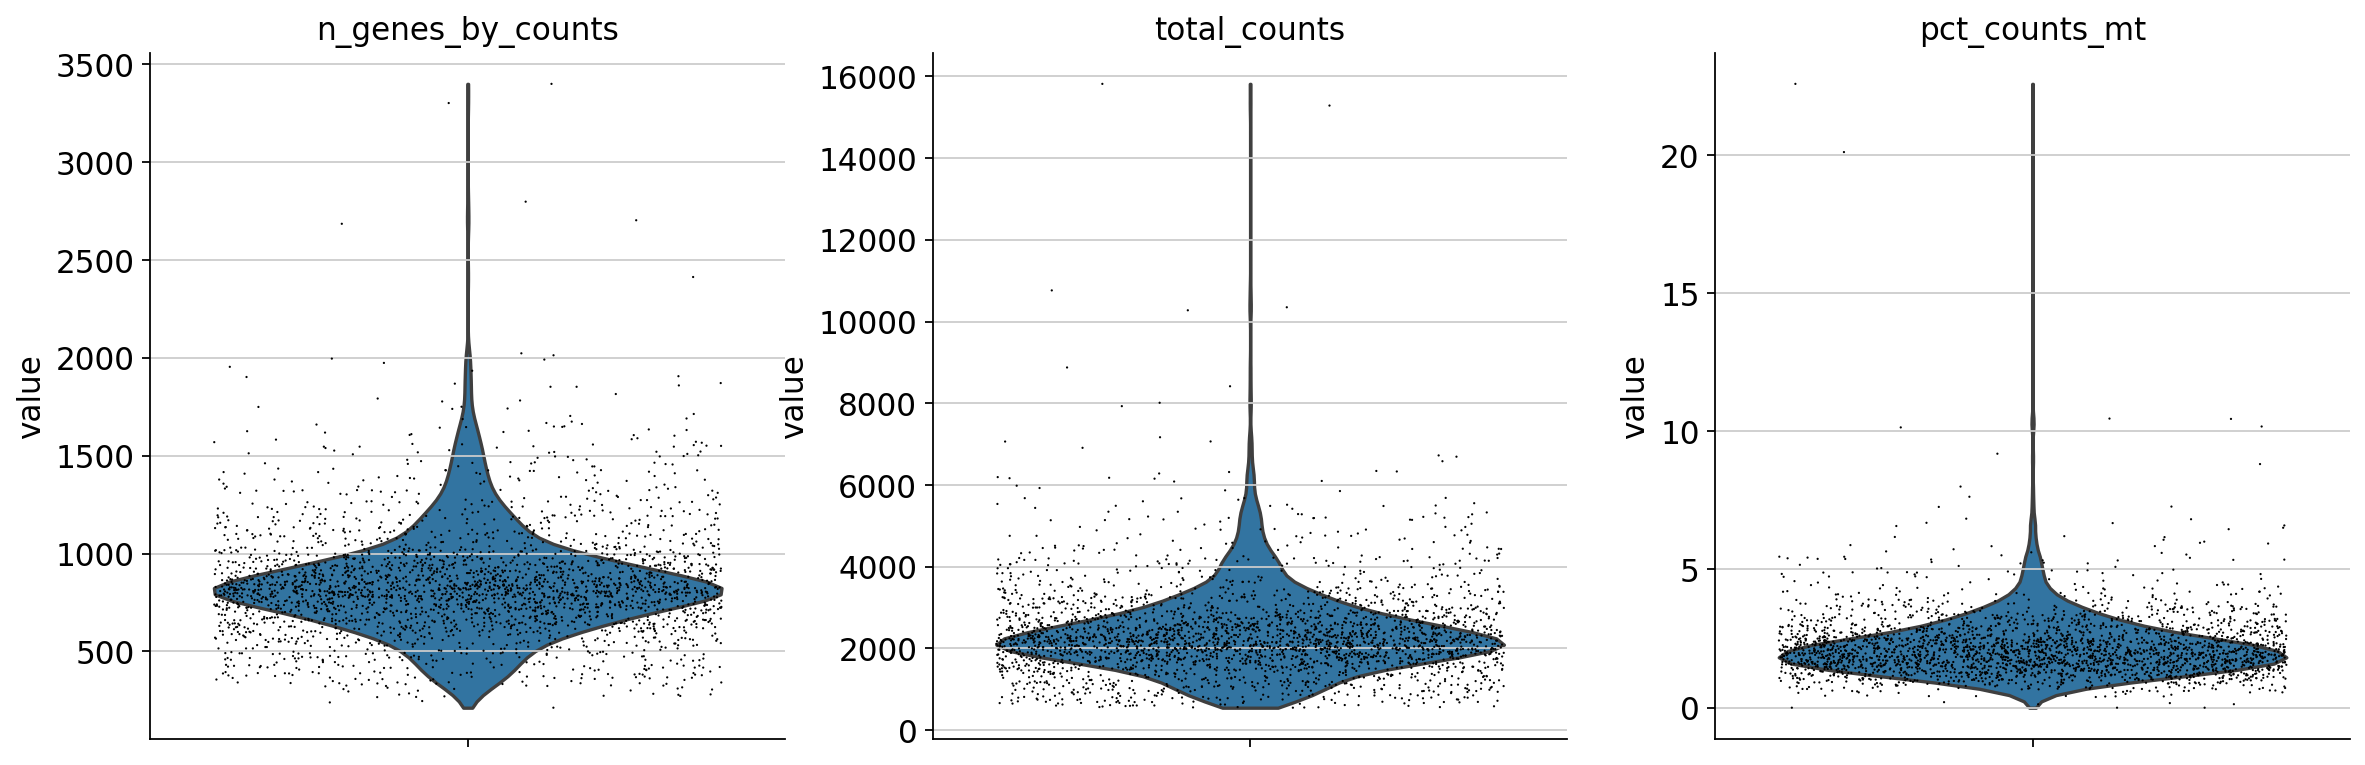

In [7]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

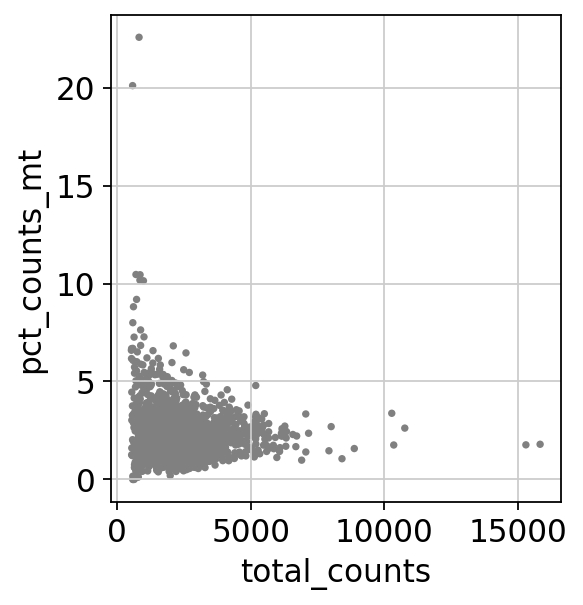

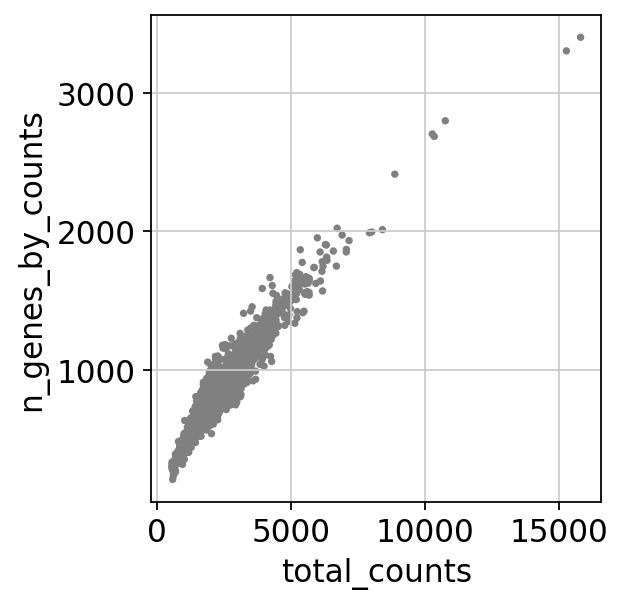

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


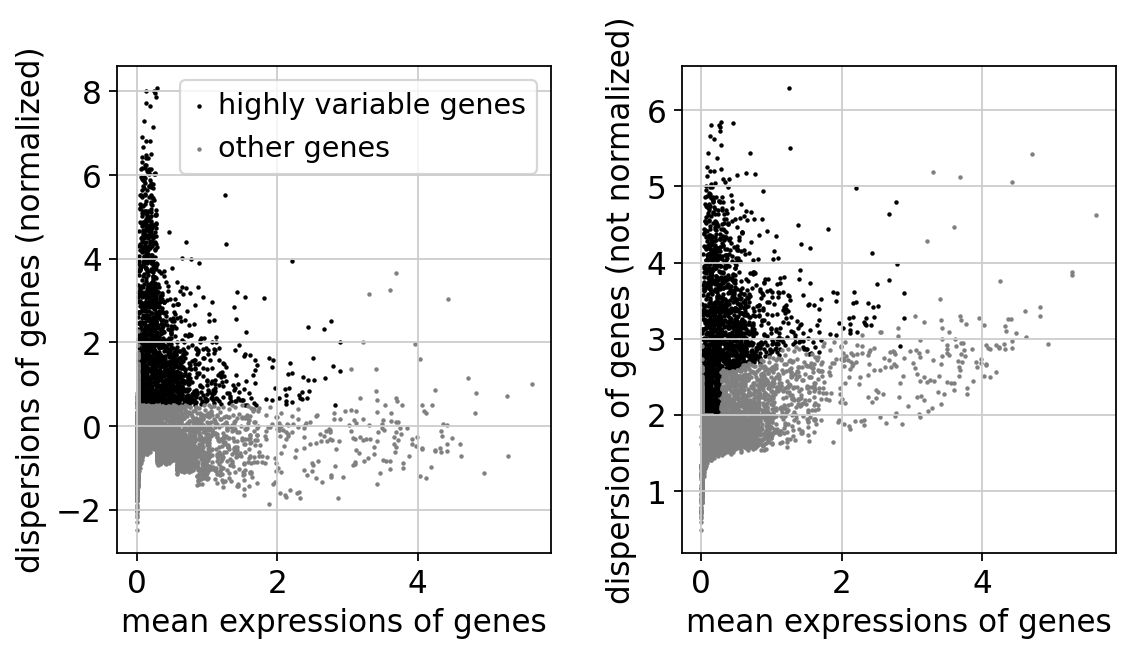

In [10]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
adata.raw = adata
adata.write(results_file)



In [11]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:17)


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


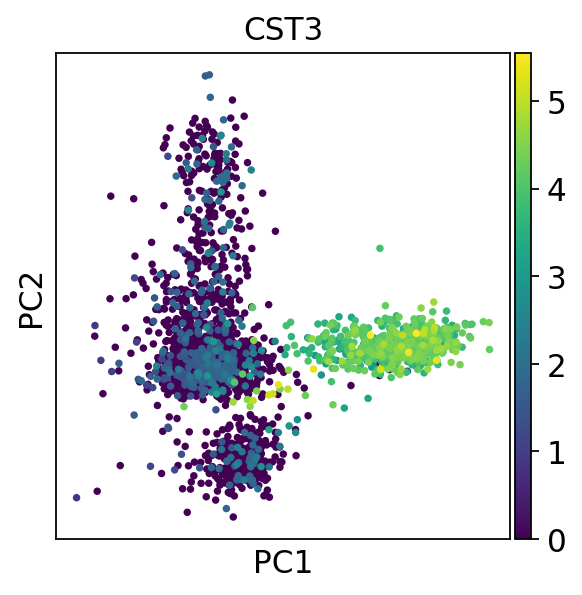

In [12]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')


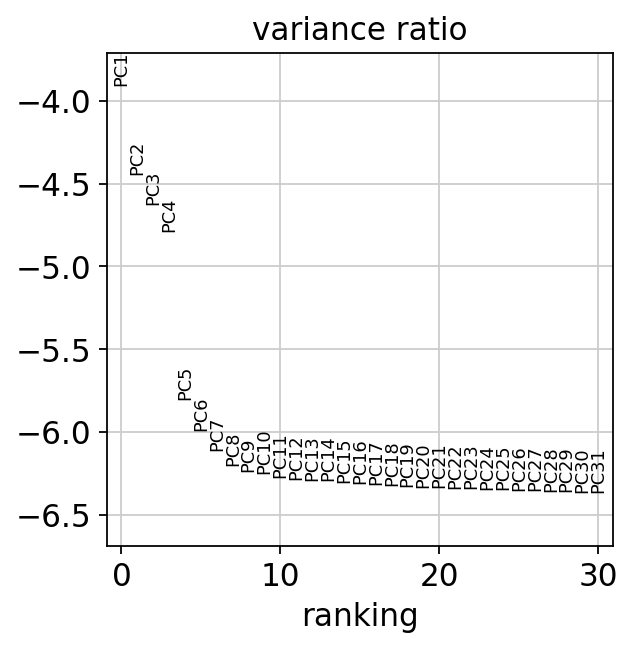

In [13]:
sc.pl.pca_variance_ratio(adata, log=True)


In [14]:
# save results
adata.write(results_file)


## Compute and embed neighborhood graph

In [24]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:09)


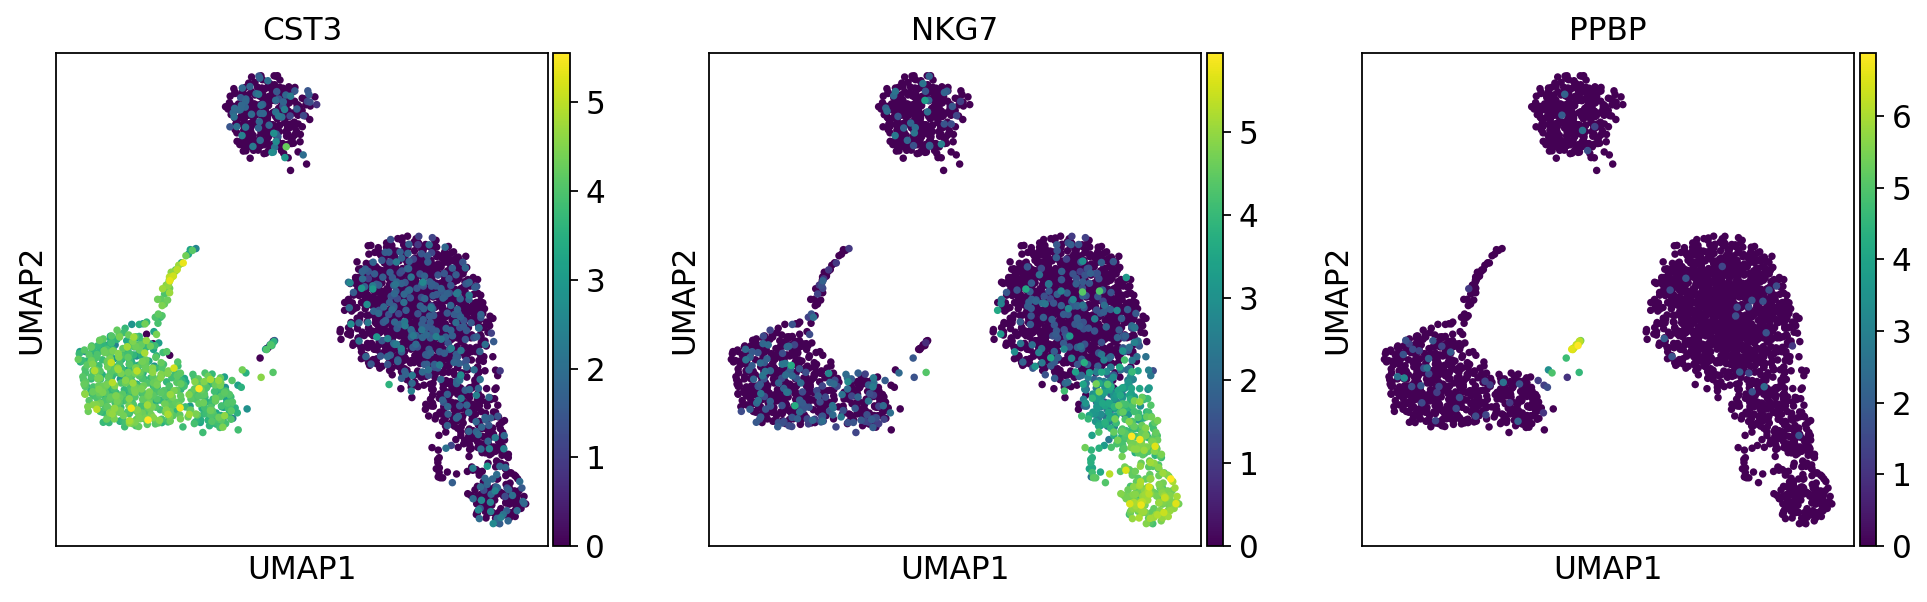

In [16]:
# plot some markers of the RAW data
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])


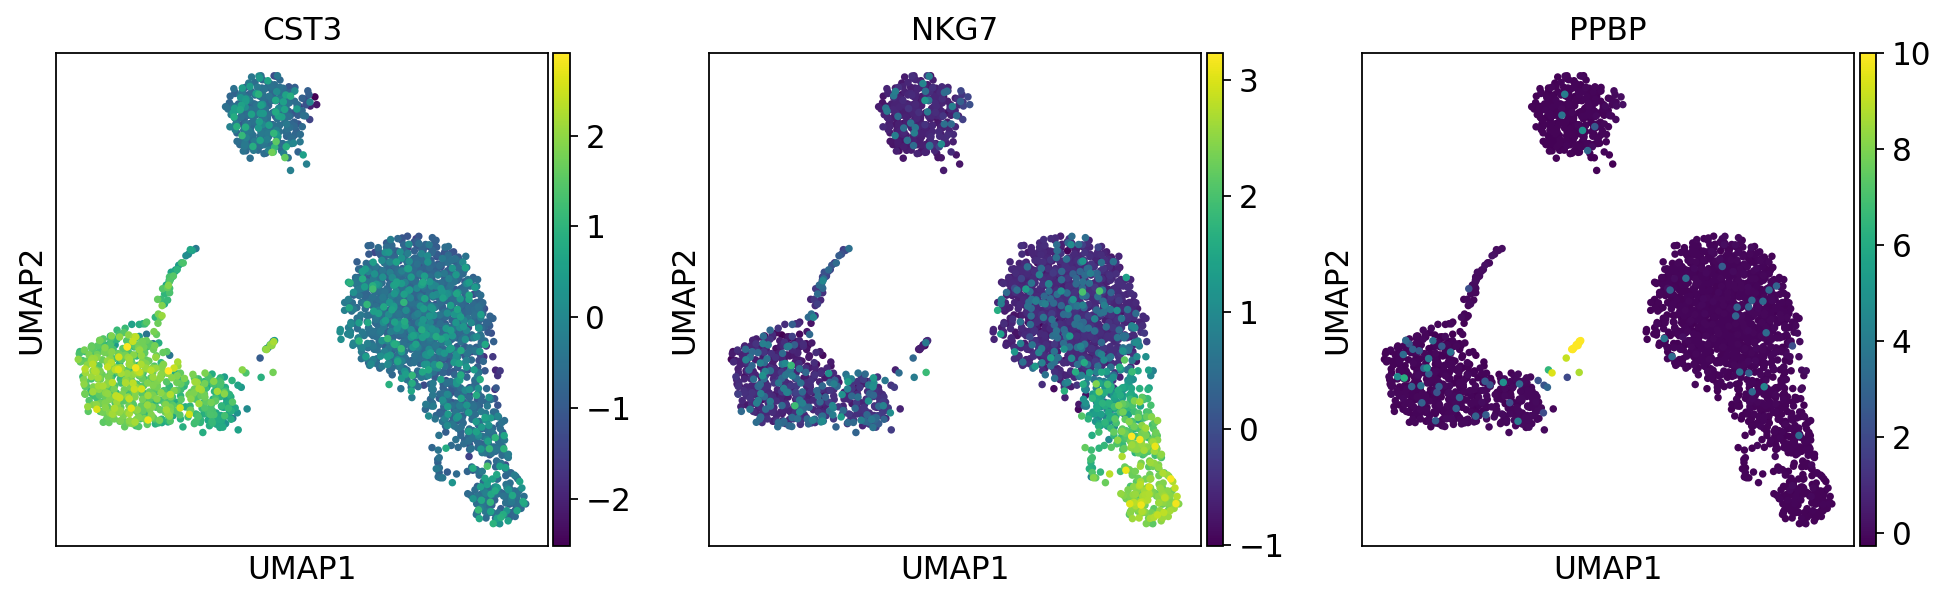

In [17]:
# now plot the corrected version (scaled+regressed)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


## Cluster the neighborhood graph

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


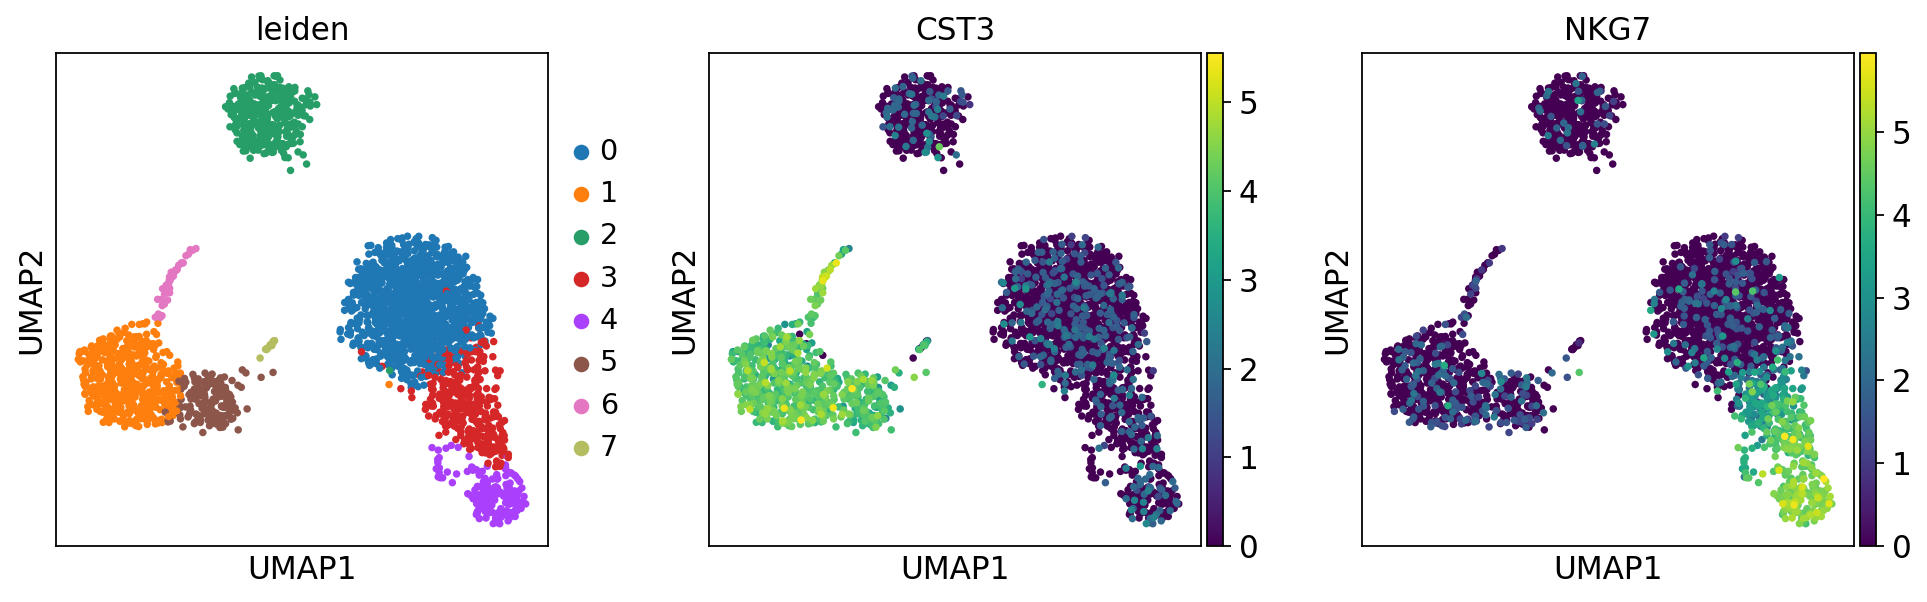

In [18]:
# lets use Leiden clustering
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

# save
adata.write(results_file)


## Find marker genes

ranking genes
    finished (0:00:00)


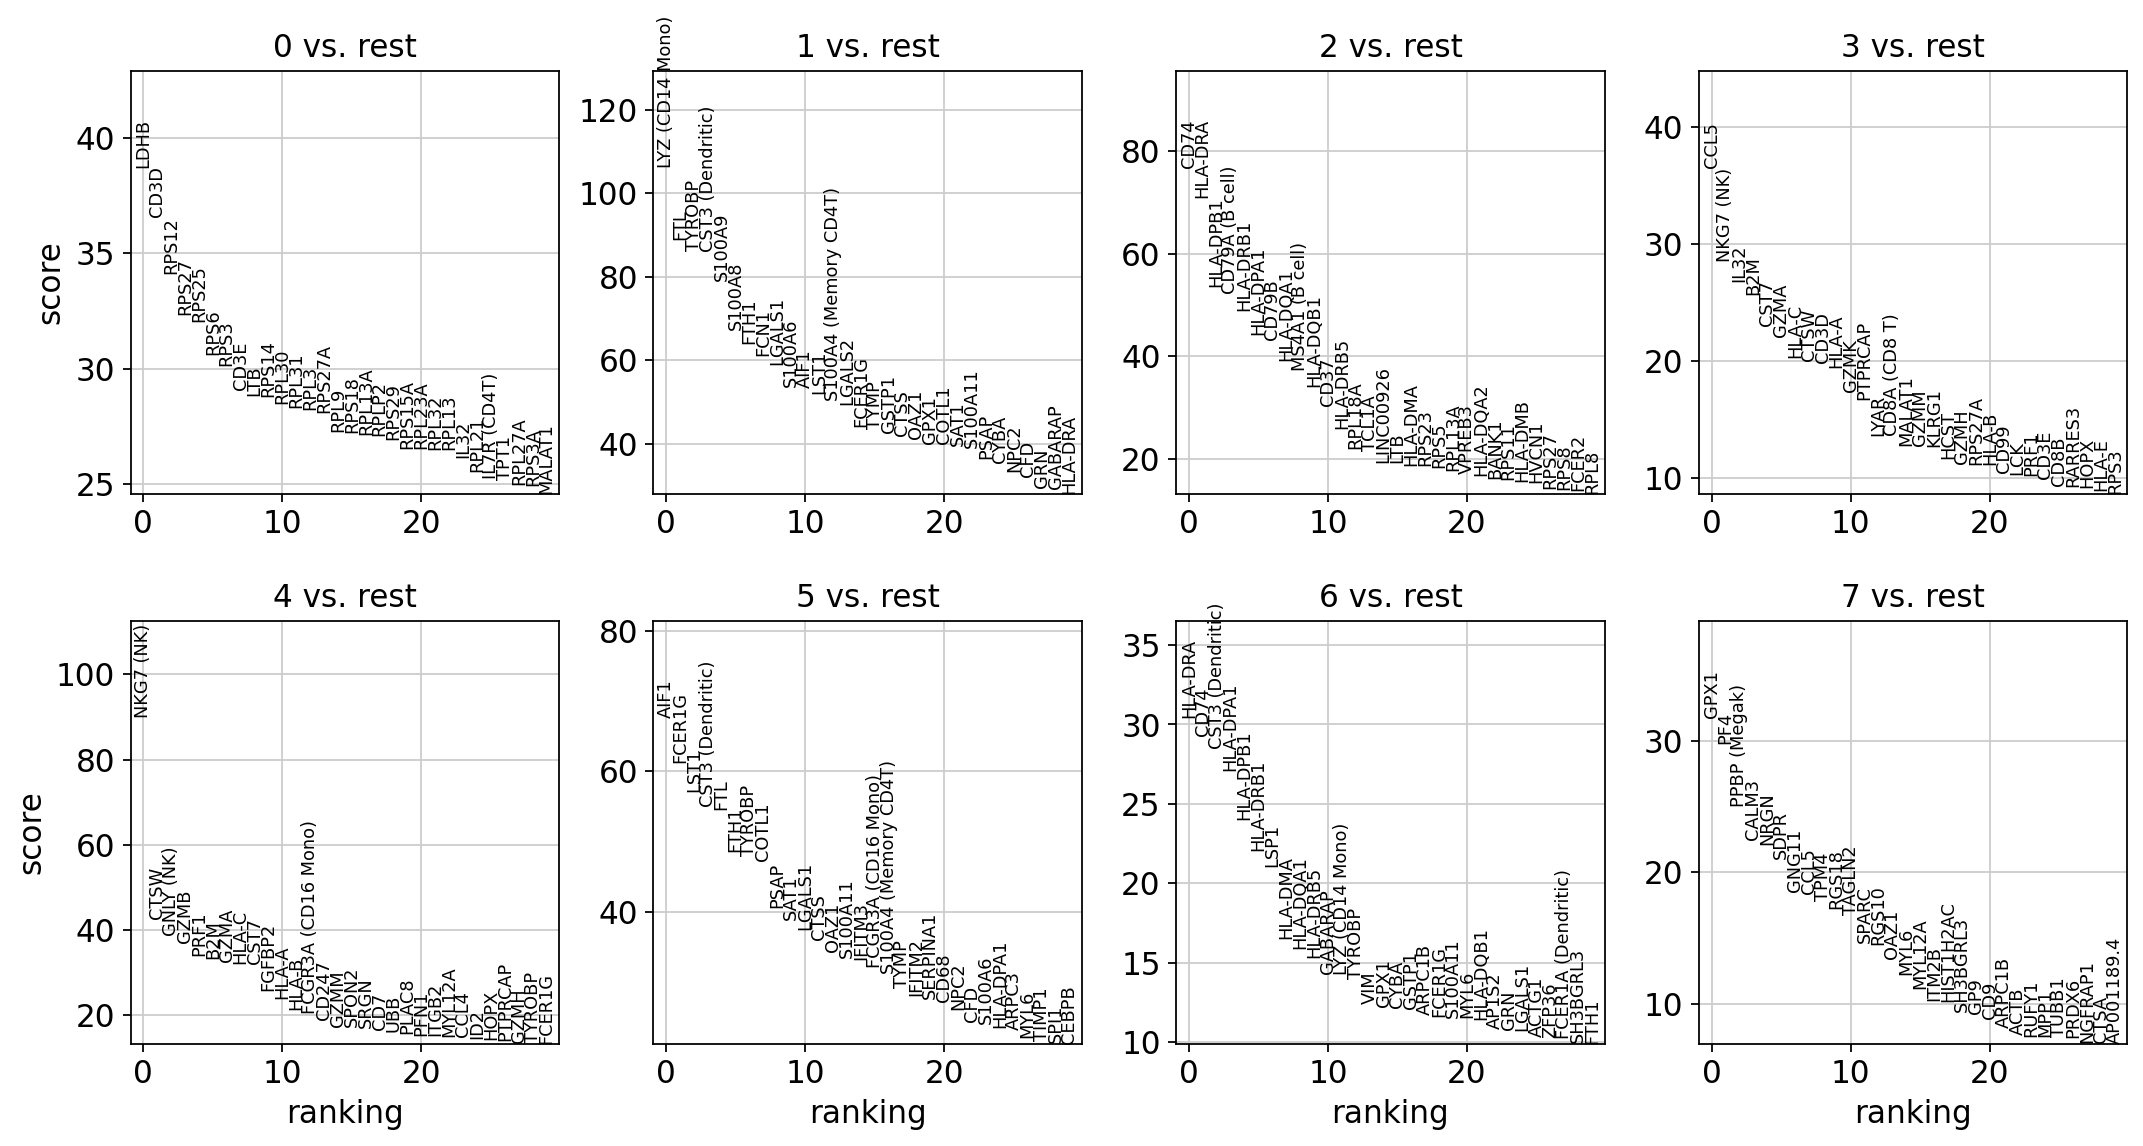

In [26]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)

ranking genes
    finished (0:00:03)


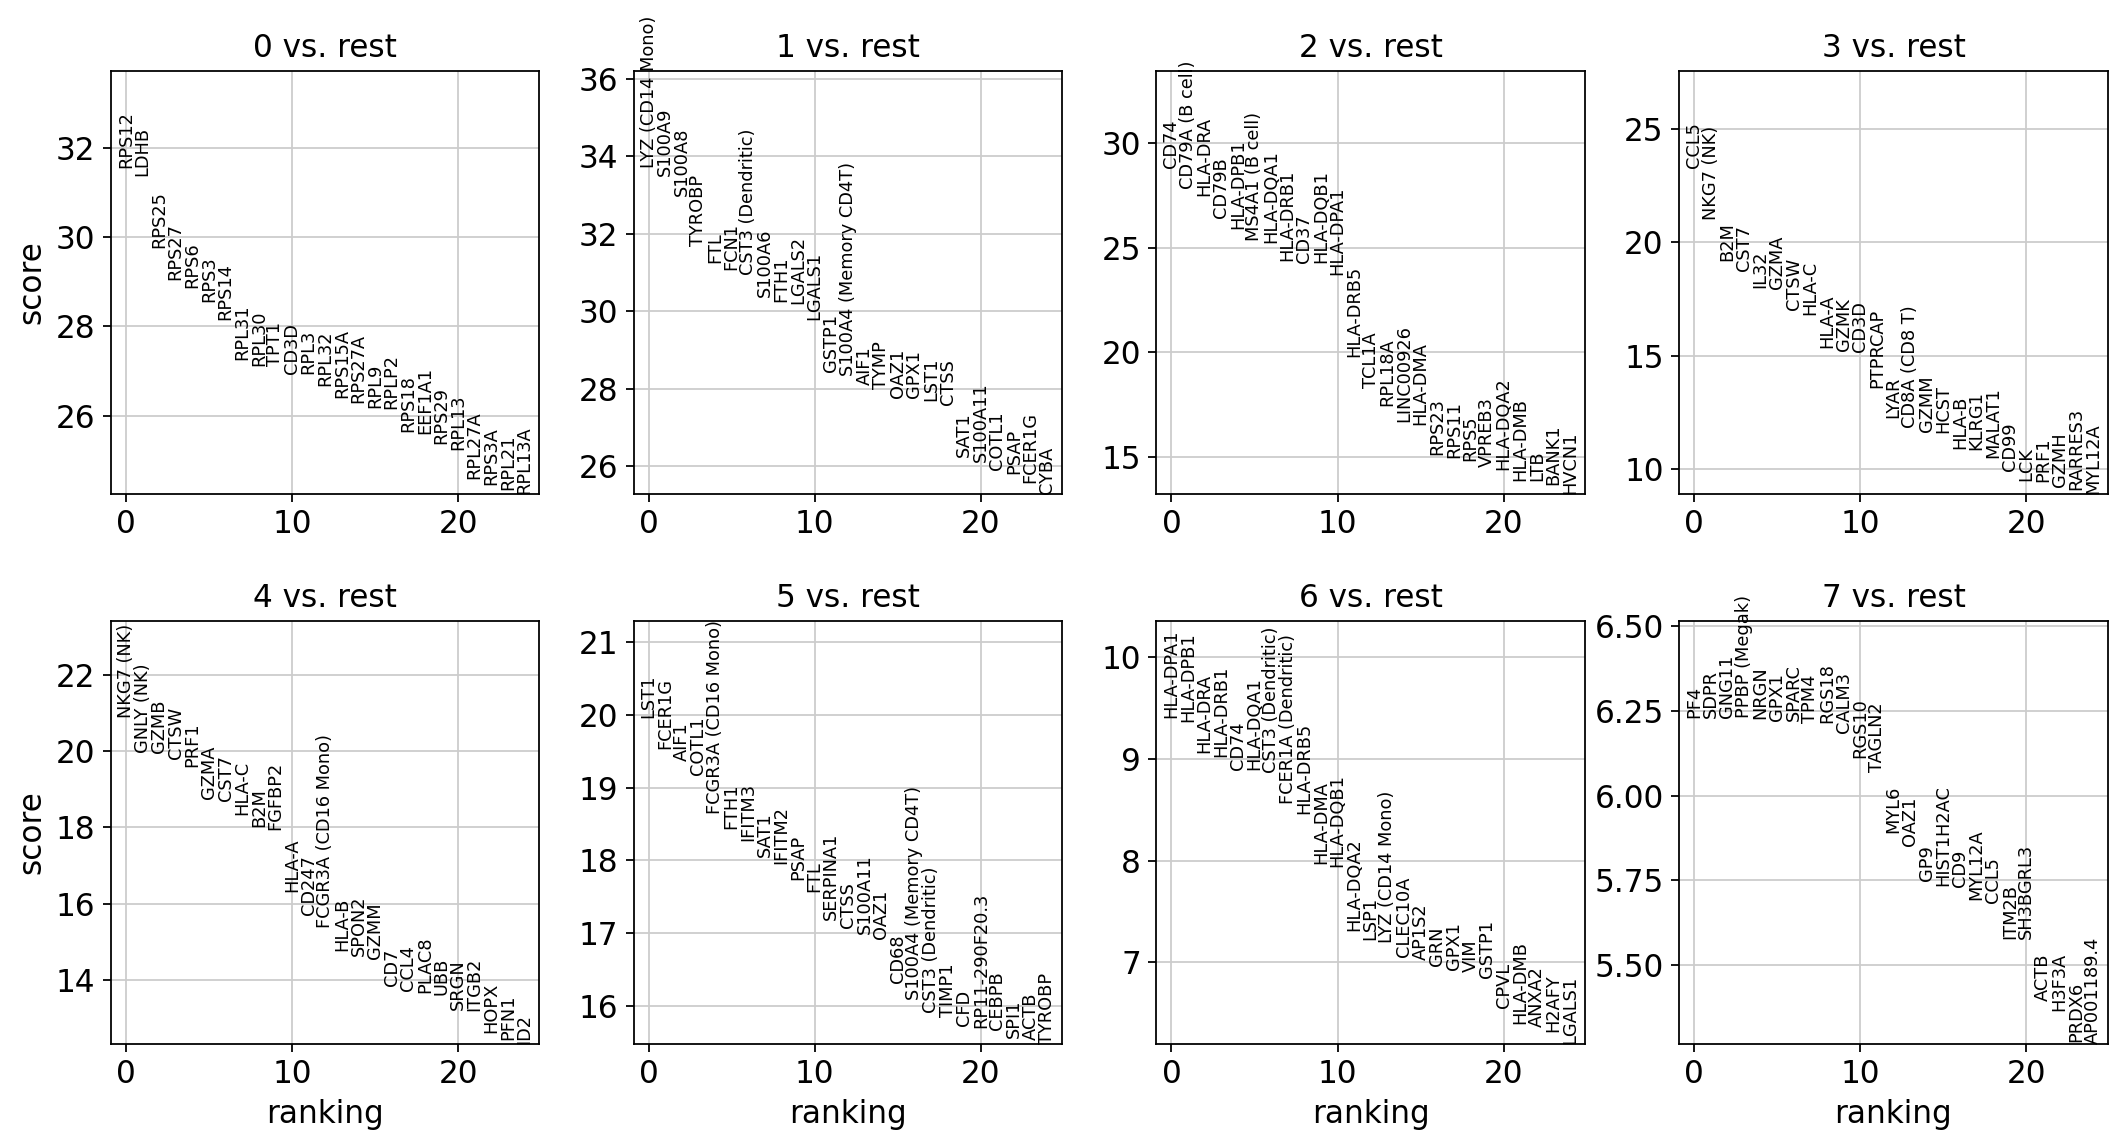

In [19]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)


In [54]:
# show top 10 genes per cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


0       1         2     3     4       5         6      7
0  RPS12     LYZ      CD74  CCL5  NKG7    LST1  HLA-DPA1    PF4
1   LDHB  S100A9     CD79A  NKG7  GNLY  FCER1G  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M  GZMB    AIF1   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7  CTSW   COTL1  HLA-DRB1   PPBP
4   RPS6     FTL  HLA-DPB1  IL32  PRF1  FCGR3A      CD74   NRGN

In [55]:
# show p-values
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  2.957044e-218     LYZ  7.634876e-249      CD74  3.043536e-182  CCL5   
1   LDHB  5.784545e-216  S100A9  4.626358e-246     CD79A  6.860832e-170  NKG7   
2  RPS25  1.873019e-194  S100A8  1.622835e-238   HLA-DRA  8.389292e-166   B2M   
3  RPS27  3.100866e-185  TYROBP  2.957652e-220     CD79B  1.171444e-153  CST7   
4   RPS6  4.301365e-183     FTL  2.479195e-214  HLA-DPB1  6.167786e-148  IL32   

             3_p   4_n           4_p     5_n           5_p       6_n  \
0  8.973144e-120  NKG7  1.203971e-96    LST1  1.322111e-88  HLA-DPA1   
1   7.478994e-98  GNLY  1.257170e-88  FCER1G  6.259712e-85  HLA-DPB1   
2   7.401007e-82  GZMB  1.429027e-88    AIF1  1.348814e-83   HLA-DRA   
3   3.420909e-78  CTSW  4.144726e-87   COTL1  5.974694e-82  HLA-DRB1   
4   1.893454e-72  PRF1  1.692100e-85  FCGR3A  1.392377e-77      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

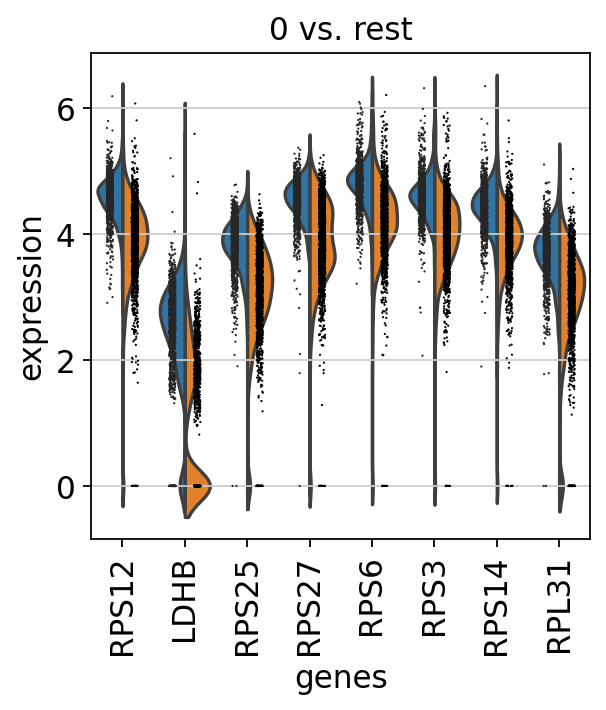

In [56]:
# show expression of top genes, 0 vs rest
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


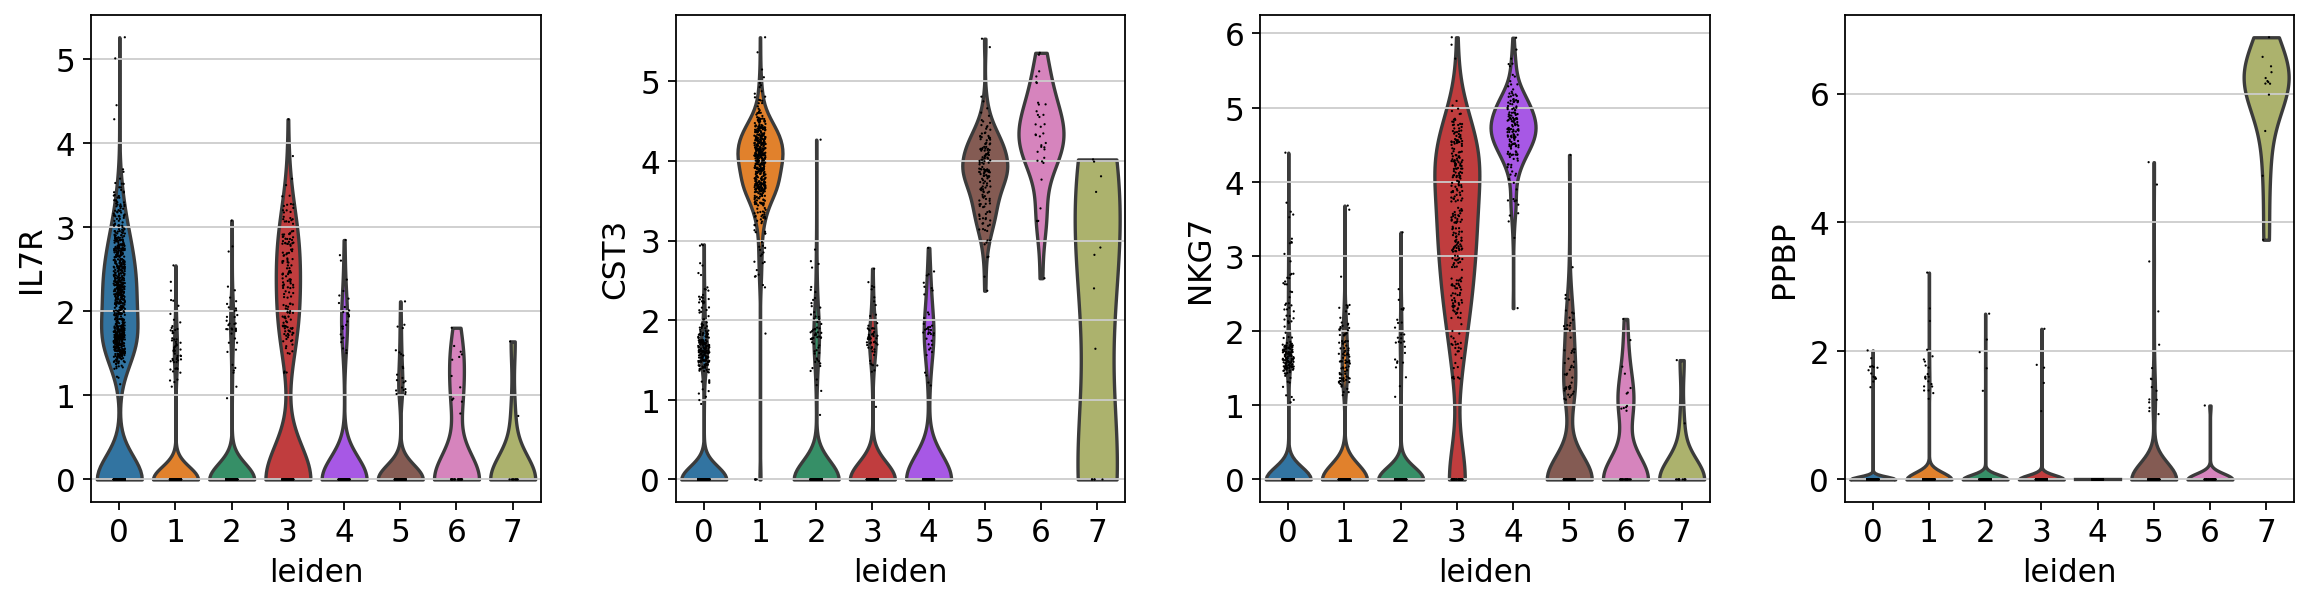

In [22]:
# show expression of some marker genes by group
sc.pl.violin(adata, ['IL7R', 'CST3', 'NKG7', 'PPBP'], groupby='leiden')


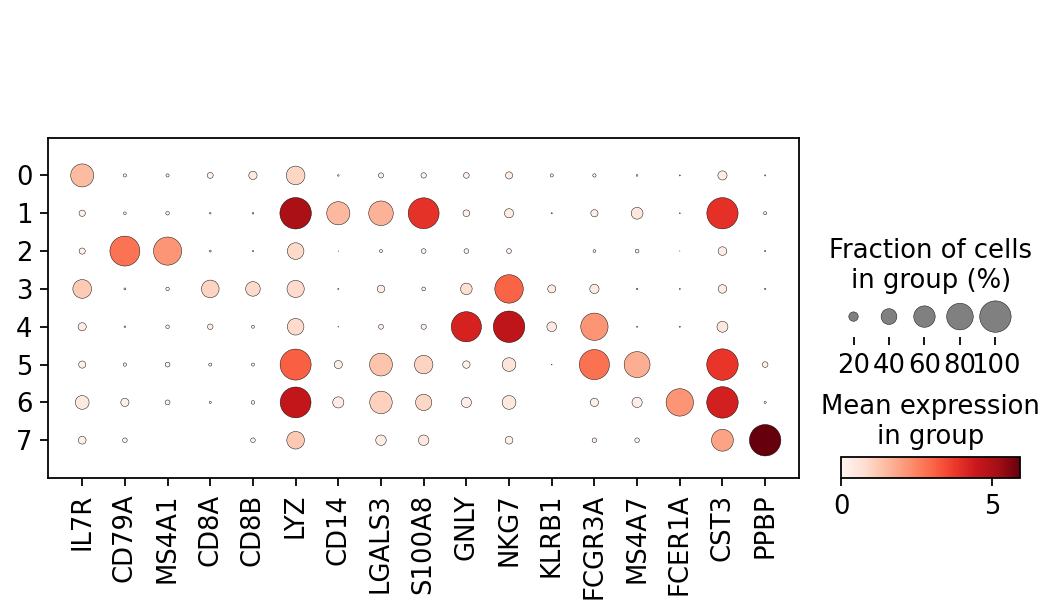

In [58]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes, groupby='leiden');


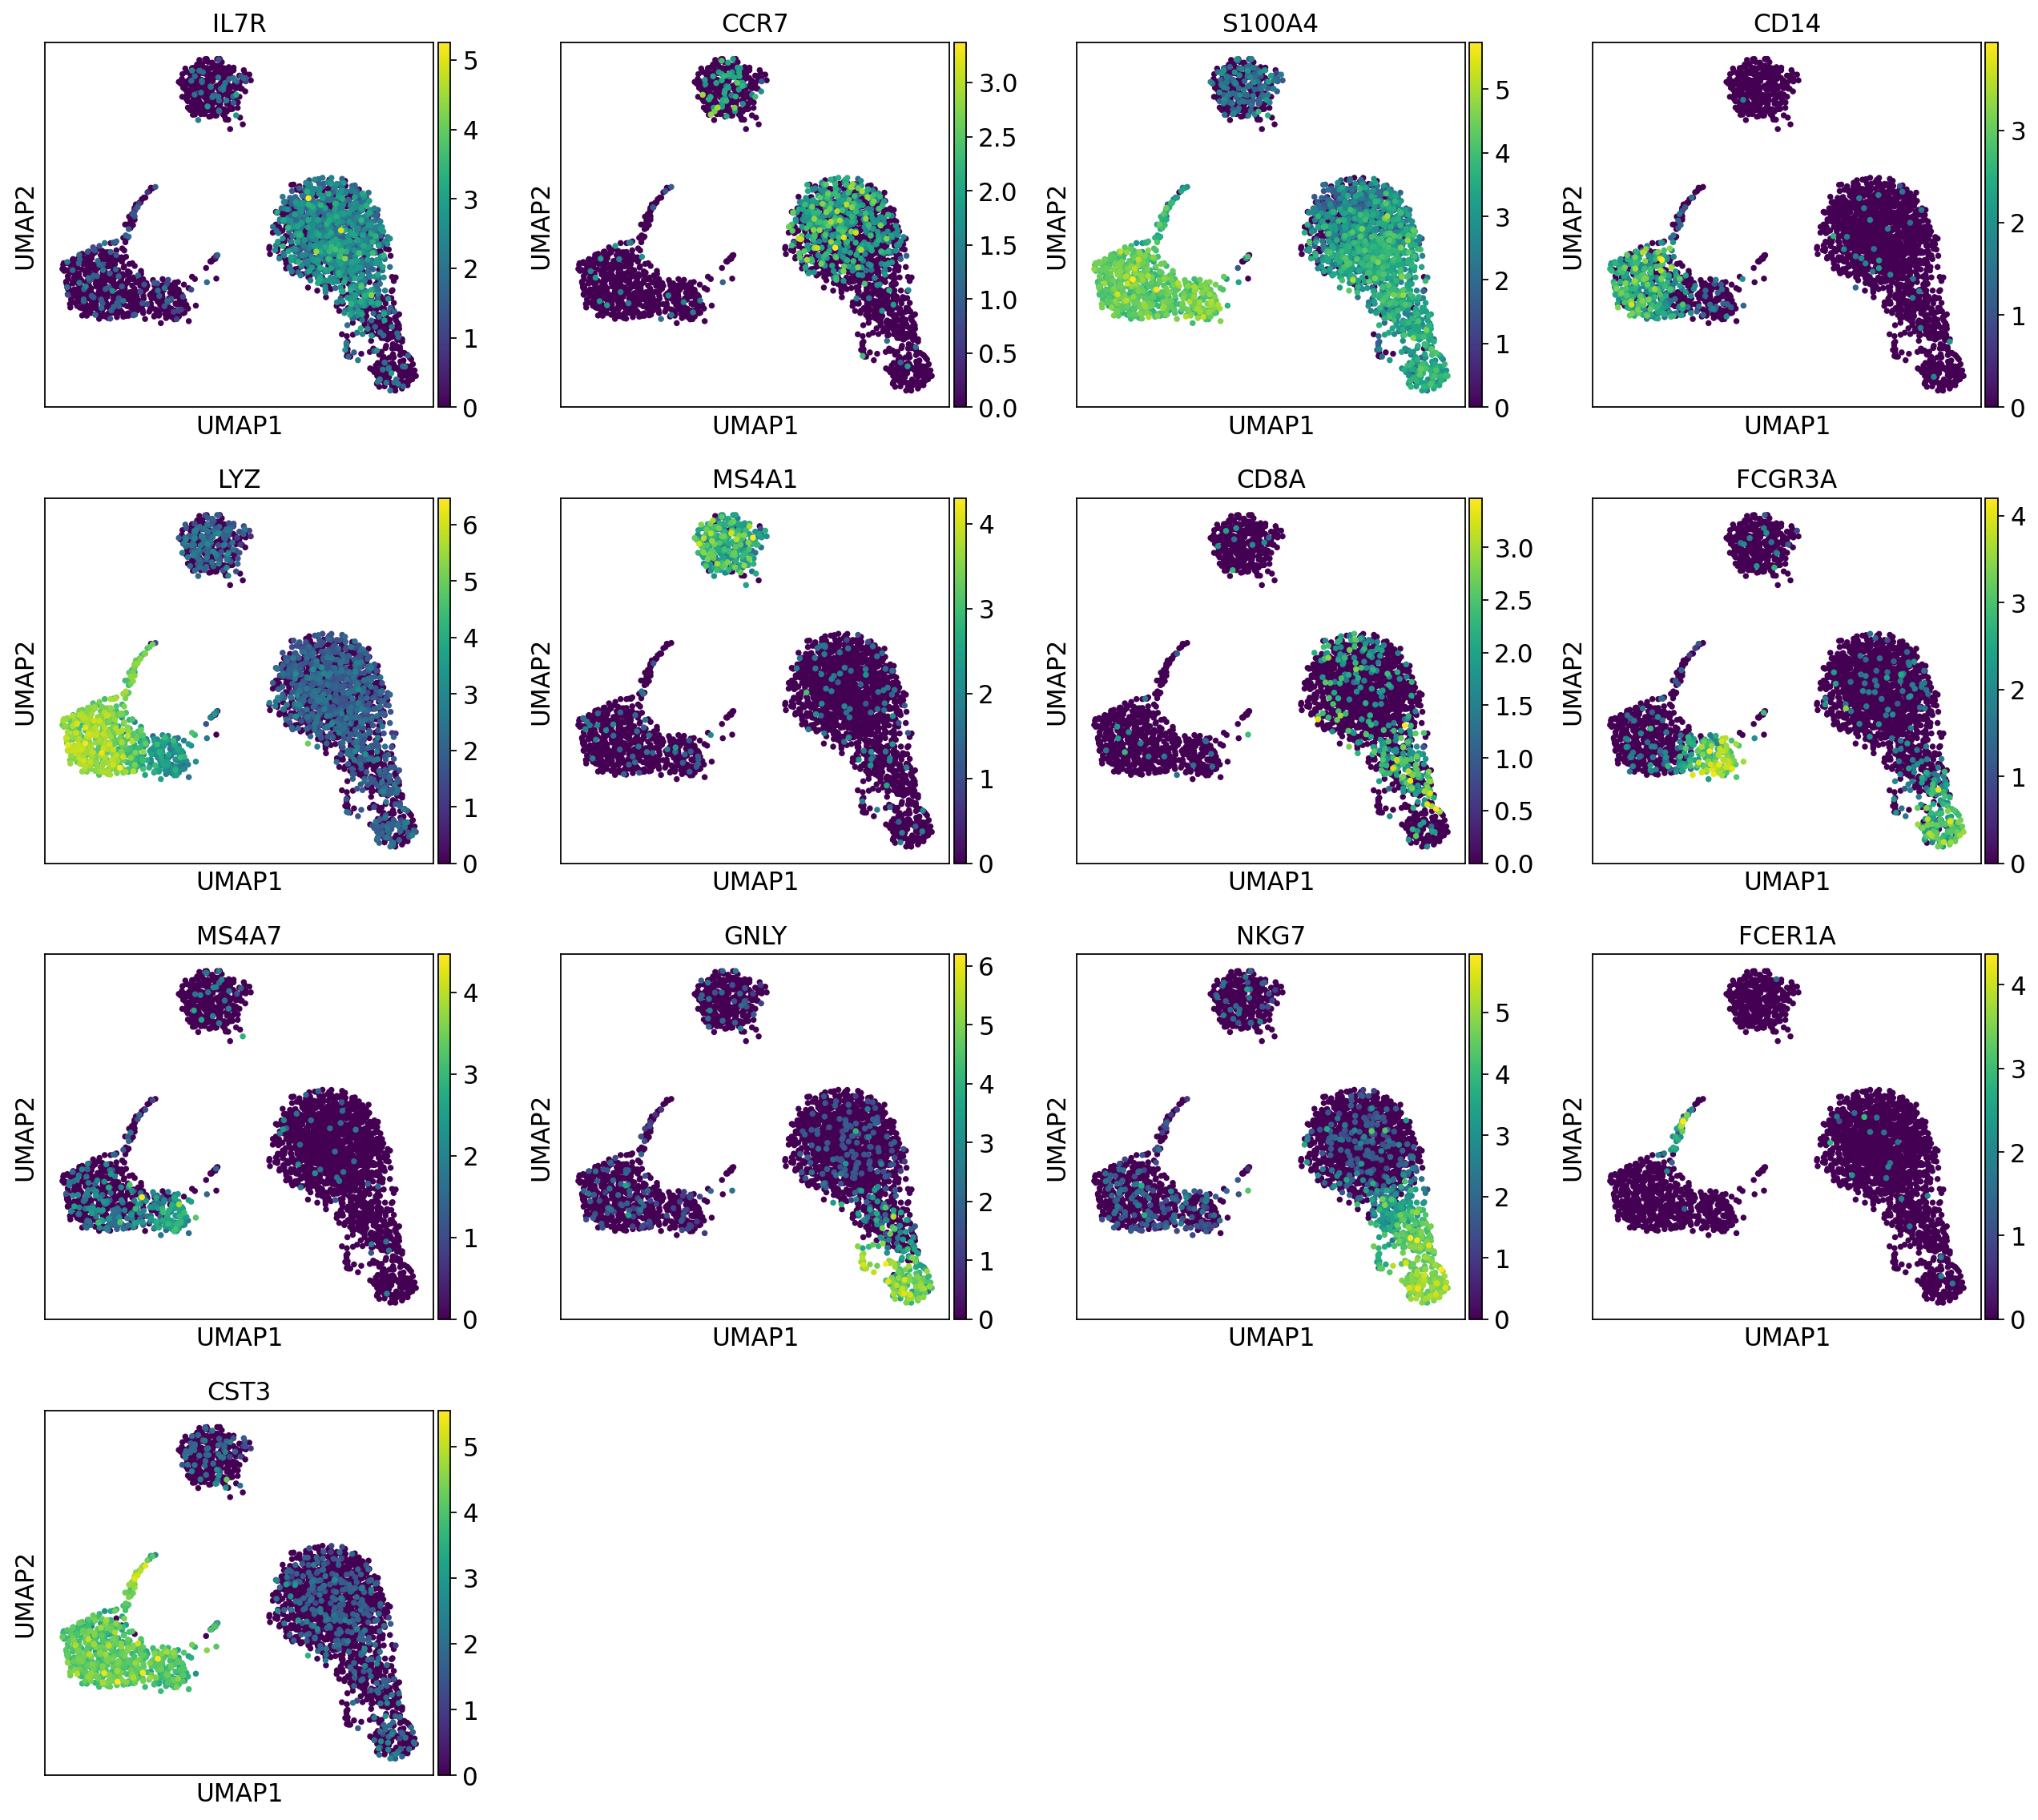

In [20]:
gene_list = ['IL7R', 'CCR7', 'S100A4', 'CD14', 'LYZ', 'MS4A1', 'CD8A',
    'FCGR3A', 'MS4A7', 'GNLY', 'NKG7', 'FCER1A', 'CST3']

sc.pl.umap(adata, color=[i for i in gene_list], color_map='viridis', legend_fontsize=8)

In [59]:
# since we know which markers work with what, we can label outselves
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']

# adata.rename_categories('leiden', new_cluster_names)
# ^^^ this should be the way, but error with updated pandas
# https://github.com/theislab/scanpy/issues/1975

adata.obs['leiden'] =adata.obs['leiden'].cat.rename_categories(new_cluster_names)


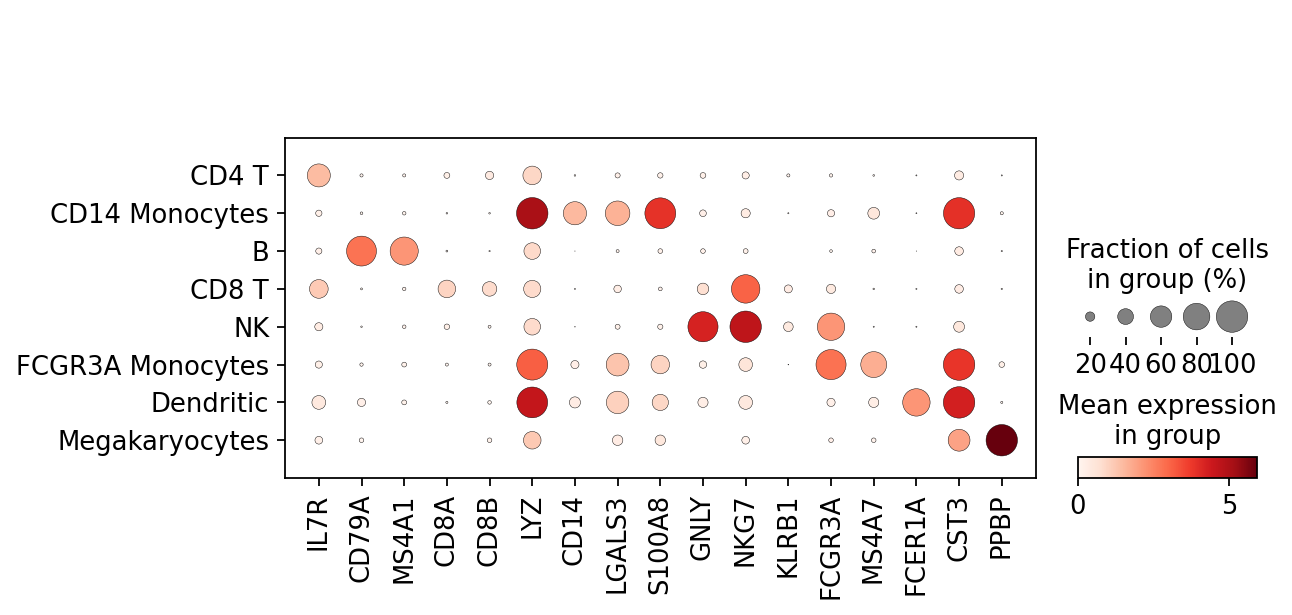

In [60]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')


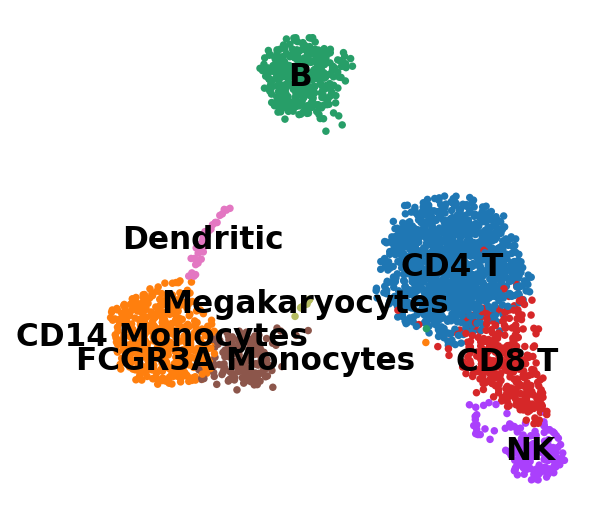

In [61]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf', )


In [62]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
